In [ ]:
from marketing import downloadData
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import Image  
import pydotplus
from statsmodels.stats.proportion import proportions_ztest

marketing_AB.csv already exists in /home/dannyzzp/projects/marketing/data/raw


In [3]:
# drop the first column which is index
df = pd.read_csv('~/projects/marketing/data/raw/marketing_AB.csv')
df = df.iloc[0:, 1:].copy()

In [4]:
df

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


## Check Experiment Group Assignment Randomization

In [5]:
dfControl = df[df['test group'] == 'psa']
dfTreatment = df[df['test group'] == 'ad']

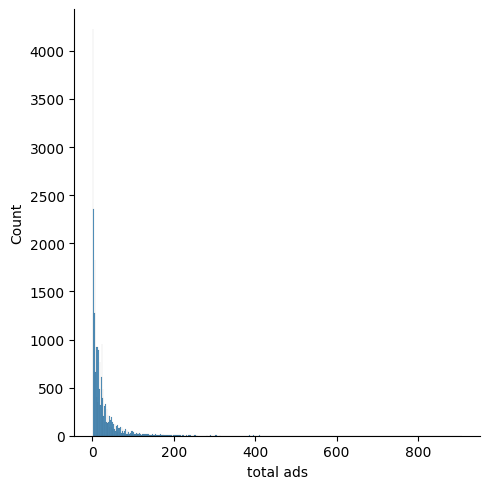

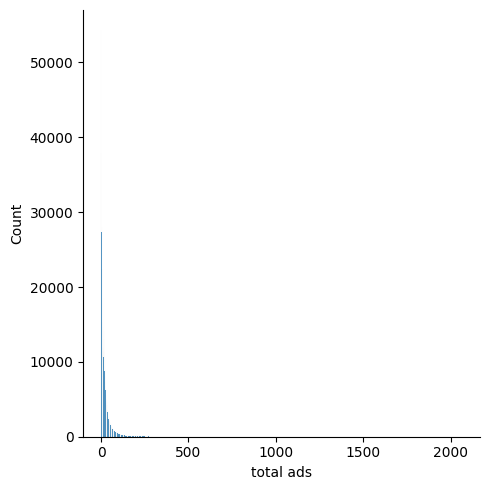

In [6]:
sns.displot(dfControl['total ads'])
sns.displot(dfTreatment['total ads'])

Step 1 <br>
H0: Average total ads viewed per person are the same between control and treatment groups <br>
H1: Average total ads viewed per person are not the same between control and treatment groups <br>

Step 2 <br>
By convention, $\alpha$ is set to be 0.05. <br>

Step 3 <br>
Calculate t-statistic and determine whether to reject H0 or not.


In [7]:
meanControl = dfControl['total ads'].mean()
sdControl = dfControl['total ads'].std() # sample standard deviation by default https://pandas.pydata.org/docs/reference/api/pandas.Series.std.html
meanTreatment = dfTreatment['total ads'].mean() 
sdTreatment = dfTreatment['total ads'].std() # sample standard deviation by default https://pandas.pydata.org/docs/reference/api/pandas.Series.std.html
nControl = dfControl.shape[0]
nTreatment = dfTreatment.shape[0]

In [8]:
(meanControl, meanTreatment, sdControl, sdTreatment)

(np.float64(24.761137561639178),
 np.float64(24.823365103431417),
 np.float64(42.86071994398073),
 np.float64(43.750456294767396))

Since the two samples are drawn from different groups, we choose to conduct an unpaired t-test. We also assume that the two groups don't share the same population standard deviation (Welch t-test).

In [9]:
#se = sp * np.sqrt((1 / nControl) + (1 / nTreatment)) # standard error
se = np.sqrt((sdControl/np.sqrt(nControl)) ** 2 + (sdTreatment/np.sqrt(nTreatment)) ** 2)
se

np.float64(0.28545147960987943)

In [10]:
t = (meanControl - meanTreatment)/se
t

np.float64(-0.2179969144923846)

In [11]:
v = ((((sdControl ** 2) / nControl) + ((sdTreatment ** 2) / nTreatment)) ** 2) / (((sdControl ** 4) / (nControl ** 2 * (nControl - 1))) + ((sdTreatment ** 4) / (nTreatment ** 2 * (nControl - 1))))
v # degrees of freedom

np.float64(25561.63346795497)

In [12]:
pValue = 2 * stats.t.sf(abs(t), df=v) # must use absolute value of t-statistic here because stats.t.sf only evaluates the upper tail area (right tail). It only evaluates the upper tail because by definition sf = 1-cdf
pValue

np.float64(0.8274332556335529)

In [13]:
2 * stats.t.sf(t, df=v)

np.float64(1.1725667443664471)

Step 4: p-value is 0.83, which is greater than the alpha 0.05. Therefore, we don't have enough confidence to reject H0 and we conclude that there isn't a significance difference in total ads between the control group and the treatment group.

Now let's perform the same hypothesis test using the scipy.stat package to see if we get the same result

In [14]:
stats.ttest_ind(dfControl['total ads'], dfTreatment['total ads'], equal_var=False)

TtestResult(statistic=np.float64(-0.21799691449238462), pvalue=np.float64(0.8274332524963), df=np.float64(25607.801394957372))

We got the same result with scipy.stat. Now we'll do a chi-squared test (independence test) for "most ads day" since it is a categorical variable 

Step 1 <br>
H0: Test group assignment and most-ads-day are independent <br>
H1: Test group assignment and most-ads-day are not independent (correlated) <br>

Step 2 <br>
By convention, $\alpha$ is set to be 0.05

Step 3 <br>
Calculate $\chi^2$-statistic and determine whether to reject H0 or not.

In [15]:
564577 * 0.1388537

78393.6053849

In [16]:
df['test group'].value_counts(normalize=False).values.reshape(-1, 1)

array([[564577],
       [ 23524]])

In [17]:
df['most ads day'].value_counts(normalize=True).values.reshape(1, -1)

array([[0.15746955, 0.1480579 , 0.14519785, 0.14110161, 0.1388537 ,
        0.13757501, 0.13174438]])

In [18]:
df['test group'].value_counts(normalize=False).values.reshape(-1, 1) * df['most ads day'].value_counts(normalize=True).values.reshape(1, -1)

array([[88903.68629878, 83590.08592232, 81975.36580791, 79662.72564406,
        78393.60555415, 77671.685503  , 74379.84526978],
       [ 3704.31370122,  3482.91407768,  3415.63419209,  3319.27435594,
         3266.39444585,  3236.314497  ,  3099.15473022]])

In [19]:
observedContingencyTable= pd.crosstab(df['test group'], df['most ads day']) # observed contingency table for chi-squared test
observedContingencyTable

most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
test group,,,,,,,
ad,88805,83571,78802,82332,79077,74572,77418
psa,3803,3502,2858,3059,3905,2907,3490


In [20]:
def customChiSquared(df):
    observed = pd.crosstab(df['test group'], df['most ads day']).values # contingency table for chi-squared test
    expected = df['test group'].value_counts(normalize=False).values.reshape(-1, 1) @ df['most ads day'].value_counts(normalize=True).values.reshape(1, -1)
    chiSquared = 0
    expectedContingencyTable = pd.DataFrame(expected, index = df['test group'].value_counts().index, columns = df['most ads day'].value_counts().index)
    # reorder the columns of expected to match observed
    expectedContingencyTable = expectedContingencyTable[observedContingencyTable.columns]
    expected = expectedContingencyTable.values
    # Calculate the value of chi-squared statistic
    for i in range(observed.shape[0]):
        for j in range(observed.shape[1]):
            chiSquared += ((observed[i][j] - expected[i][j]) ** 2)/expected[i][j]
    dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)
    return [expectedContingencyTable, chiSquared, dof]

In [21]:
expectedContingencyTable, chiSquared, dof = customChiSquared(df)

In [22]:
expectedContingencyTable

most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
test group,,,,,,,
ad,88903.686299,83590.085922,78393.605554,81975.365808,79662.725644,74379.84527,77671.685503
psa,3704.313701,3482.914078,3266.394446,3415.634192,3319.274356,3099.15473,3236.314497


In [23]:
chiSquared, dof

(np.float64(235.61445227291105), 6)

In [24]:
pValue = 2 * stats.chi2.sf(chiSquared, df=dof)
pValue

np.float64(9.698135328596531e-48)

Step 4: p-value is basically 0, and we therefore reject H0, meaning that there is a very strong correlation between test group assignment and most-ads-day.

We can verify our conclusion by using the chi-squared testing approach provided by the scipy.stats package

In [25]:
stats.chi2_contingency(observedContingencyTable)

Chi2ContingencyResult(statistic=np.float64(235.61445227291117), pvalue=np.float64(4.849067664297987e-48), dof=6, expected_freq=array([[88903.68629878, 83590.08592232, 78393.60555415, 81975.36580791,
        79662.72564406, 74379.84526978, 77671.685503  ],
       [ 3704.31370122,  3482.91407768,  3266.39444585,  3415.63419209,
         3319.27435594,  3099.15473022,  3236.314497  ]]))

<Axes: xlabel='most ads day', ylabel='proportion'>

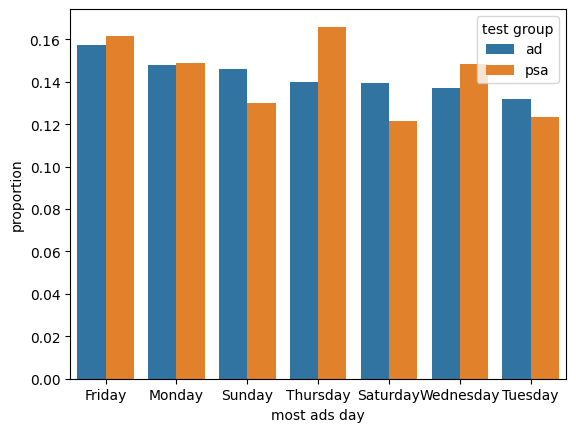

In [26]:
df['most ads day'].groupby(df['test group']).value_counts(normalize=True).rename('proportion').reset_index().pipe((sns.barplot, "data"), x='most ads day', y='proportion', hue='test group')

*"In practice, it is pretty frequent that test and control distributions are different, invalidating the test results. The number one reason for that is bugs or bias in the randomization algorithm that assigns users to test and control, leading to over/under representation of certain segments. That is, we might have more US users in control, but those users have higher conversion rate, so the difference we see in the metric is not only affected by the feature change that we are testing."* -- Giulio Palombo

Let's run the same chi-squared test for the other categorical variable "most ads hour"

In [27]:
df

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


Step 1 <br>
H0: Test group assignment and most-ads-hour are independent <br>
H1: Test group assignment and most-ads-hour are not independent (correlated) <br>

Step 2 <br>
By convention, $\alpha$ is set to be 0.05

Step 3 <br>
Calculate $\chi^2$-statistic and determine whether to reject H0 or not.

In [28]:
observedContingencyTable = pd.crosstab(df['test group'], df['most ads hour'])
stats.chi2_contingency(observedContingencyTable)

Chi2ContingencyResult(statistic=np.float64(192.29173193613582), pvalue=np.float64(1.094573971081402e-28), dof=23, expected_freq=array([[5.31456038e+03, 4.60992033e+03, 5.11968036e+03, 2.57184018e+03,
        6.93120049e+02, 7.34400052e+02, 1.98528014e+03, 6.14880044e+03,
        1.69219212e+04, 2.97638421e+04, 3.73814426e+04, 4.43616031e+04,
        4.54060832e+04, 4.57488032e+04, 4.38220831e+04, 4.28956830e+04,
        3.60643226e+04, 3.35884824e+04, 3.10300822e+04, 2.91379221e+04,
        2.77660820e+04, 2.87769620e+04, 2.53747218e+04, 1.93593614e+04],
       [2.21439623e+02, 1.92079673e+02, 2.13319637e+02, 1.07159818e+02,
        2.88799509e+01, 3.05999480e+01, 8.27198593e+01, 2.56199564e+02,
        7.05078801e+02, 1.24015789e+03, 1.55755735e+03, 1.84839686e+03,
        1.89191678e+03, 1.90619676e+03, 1.82591690e+03, 1.78731696e+03,
        1.50267744e+03, 1.39951762e+03, 1.29291780e+03, 1.21407794e+03,
        1.15691803e+03, 1.19903796e+03, 1.05727820e+03, 8.06638628e+02]]))

<Axes: xlabel='most ads hour', ylabel='proportion'>

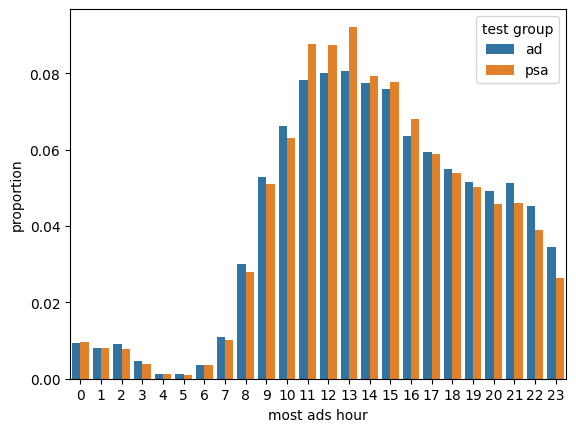

In [29]:
df['most ads hour'].groupby(df['test group']).value_counts(normalize=True).rename('proportion').reset_index().pipe((sns.barplot, "data"), x='most ads hour', y='proportion', hue='test group')

Again, H0 is rejected and there is a strong correlation between test group and most-ads-hour

Alternative to t-testing and chi-squared testing, we can use tree-based models to verify group assignment randomization across all independent variables

In [30]:
# One-hot encode all categorical variables
df_dummy = pd.get_dummies(df, columns=['most ads day','most ads hour'])

train_cols = df_dummy.drop(['user id','converted','test group'], axis=1).fillna(0)
  
tree=DecisionTreeClassifier(
    #change weights. Our df_results set is now perfectly balanced. It makes easier to understand the tree output
    class_weight="balanced",
    #only split if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.0001,
    max_depth = 3
    )
tree.fit(train_cols,df['test group'])

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0001
,class_weight,'balanced'


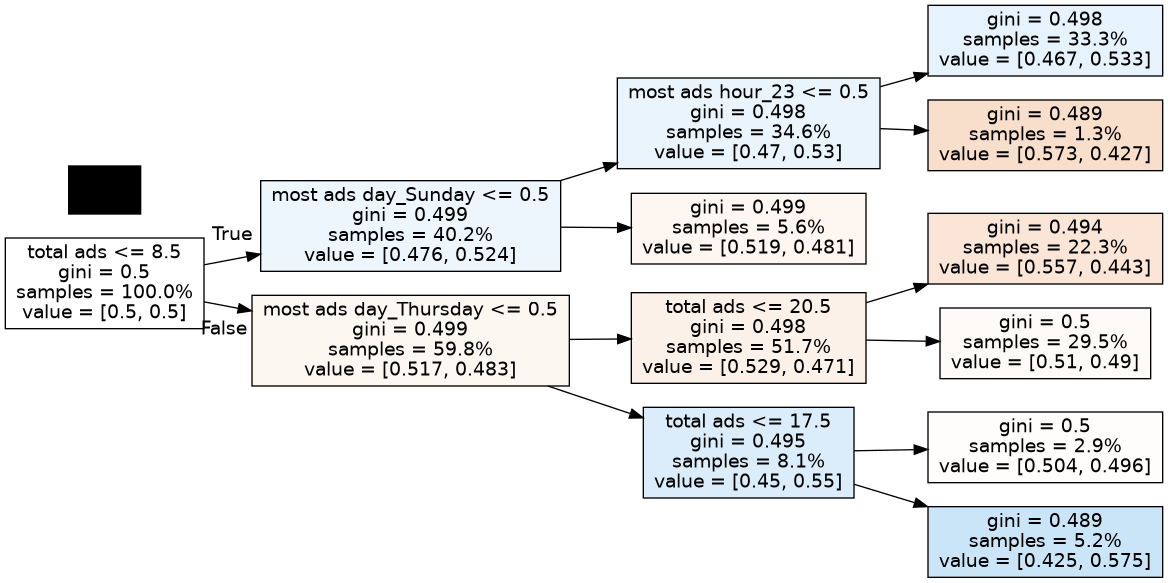

In [31]:
# Deicision tree visualization
dot_data = export_graphviz(tree, feature_names=train_cols.columns, proportion=True, rotate=True, filled=True) # run "sudo apt-get install graphviz" command on Ubuntu to install graphviz on top of the pip installation of the package 
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

As shown by the decision tree above, at least one of the independent variables have a moderate correlation with the group assignment variable. We can potentially use permutation_importance from sklearn to calculate feature importance

## A/B Test: "ad" or "psa", which one leads to a higher conversion rate?

There are two ways to approach this: two-proportion z-test vs chi-squared test, and both are equivalent mathematically (this can be proved).

### Proportion Z-Test:

Step 1 <br>
Convert df['test group'] to conversion rate by taking the sum of the variable and divide it by the count of df['test group'] </br>
Since conversion rate is the proportion statistic of the binary variable df['test group'], we run a z-test (because by convention, we assume the variance of population proportion is "known") instead of a t-test.

In [32]:
pControl = dfControl.converted.sum()/dfControl.shape[0] # conversion rates
pTreatment = dfTreatment.converted.sum()/dfTreatment.shape[0]

Step 2 <br>
H0: pControl - pTreatment == 0  <br>
H1: pControl - pTreatment !=0 <br>

Step 3 <br>
By convention, $\alpha$ is set to be 0.05

Step 4 <br>
Calculate z-statistic and determine whether to reject H0 or not.

In [33]:
pControl, pTreatment

(np.float64(0.01785410644448223), np.float64(0.025546559636683747))

In [ ]:
pPooled = (dfControl.converted.sum() + dfTreatment.converted.sum())/(dfControl.shape[0] + dfTreatment.shape[0])
pPooled

np.float64(0.02523886203220195)

In [35]:
z = (pControl - pTreatment)/np.sqrt(pPooled * (1 - pPooled) * ((1/dfControl.shape[0]) + (1/dfTreatment.shape[0])))
z

np.float64(-7.3700781265454145)

In [36]:
pValue = stats.norm.sf(abs(z)) * 2
pValue

np.float64(1.7052807161559727e-13)

verify the z score and p value using the statsmodels.stats package

P-value is close to 0, we reject H0 and conclude that population proportion between control and treatment groups are not the same. Therefore, we conclude that treatment group/ad should be rolled per A/B test result

Now we approach the same question using a chi-squared test

In [60]:
stats.chi2_contingency(pd.crosstab(index = df['test group'], columns= df['converted'])) 

Chi2ContingencyResult(statistic=np.float64(54.005823883685245), pvalue=np.float64(1.9989623063390075e-13), dof=1, expected_freq=array([[550327.71899045,  14249.28100955],
       [ 22930.28100955,    593.71899045]]))

In [ ]:
stats.chi2_contingency(pd.crosstab(index = df['test group'], columns= df['converted']), correction=False) # correction is set to True by default

Chi2ContingencyResult(statistic=np.float64(54.318051591383124), pvalue=np.float64(1.7052807161560133e-13), dof=1, expected_freq=array([[550327.71899045,  14249.28100955],
       [ 22930.28100955,    593.71899045]]))

Chi-square test returns the same p-value as z-test. Note that when dof==1 (2x2 contingency table), Yates' correction for continuity is applied to make p-value more conservative. Only when it's false are z-test and chi-square test equivalent

## Did we collect enough of data points for the test to be valid? Explain why
We can determine the minimum sample size required to reach statistical significance, statistical power, and minimal detectable effect. Once the minimum sample size is determined, we compare it to the actual sample sizes


We set 	$\alpha$ to be 0.05, 	$\beta$ to be 0.2, and minimal detectable effect (MDE) to be 10%

In [77]:
alpha = 0.05
beta = 0.2
mde = 0.1

H0: pControl - pTreatment == 0 </br>
H1: pControl - pTreatment != 0

In [84]:
k = dfTreatment.shape[0]/dfControl.shape[0] 
qControl = 1 - pControl
qTreatment = 1 - pTreatment
pPooled = (pControl + k * pTreatment)/(1 + k)
qPooled = 1 - pPooled
z1 = stats.norm.ppf(1 - alpha/2) # Z(1-alpha/2)
z2 = stats.norm.ppf(1 - beta) # Z(1-beta)

k, qControl, qTreatment, pPooled, qPooled, z1, z2

(24.00004250977725,
 np.float64(0.9821458935555177),
 np.float64(0.9744534403633163),
 np.float64(0.025238862032201954),
 np.float64(0.9747611379677981),
 np.float64(1.959963984540054),
 np.float64(0.8416212335729143))

In [75]:
stats.norm.ppf(0.05/2)

np.float64(-1.9599639845400545)

In [78]:
df

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [85]:
n1 = ((np.sqrt(pPooled * qPooled * (1 + 1/k)) * z1 + np.sqrt(pControl * qControl + (pTreatment * qTreatment)/k) * z2) ** 2)/(mde ** 2)
n2 = k * n1
n1, n2, dfControl.shape[0] , dfTreatment.shape[0]

(np.float64(18.357487726055687), np.float64(440.5804857980506), 23524, 564577)

From our calculation, we have collected more than enough of data points to detect a 10% MDE. 

## You have reached the end of this analysis. Thank you.